# PATH COVERING ALGORITHM

In [75]:
# required for display purpose only , comment when not using 
%matplotlib nbagg

# lib required for functioning.
import numpy as np
from scipy.interpolate import splprep, splev
from shapely.geometry import Polygon, Point
import pandas as pd


#lib required for visualization only
import matplotlib.pyplot as plt



In [76]:
#parameters required
file_name = 'obs'
longitude_upper_limit = 1
latitude_upper_limit = 1
limit = 3
#separator

### LOAD DATA

In [77]:
df = pd.read_csv(file_name, sep=" ", header=None)
#lsit of points in format [Latitude,Longitude] 
coordinates  = df.apply(pd.to_numeric, args=('coerce',)).values

#contains points for farm boundary and each obstacle recorded 
list_of_boundaries = []

#temp for calculation purpose
boundary = []

# loop to separate points based on boundary from file read (coordinates) and store it into list of boundaries
for i in coordinates:
    if np.isnan(i).any():
        list_of_boundaries.append(boundary)
        boundary = []
        continue
    boundary.append(i)


In [78]:
# will convert points under list_of_boundaries into indiv polygon and store into list_all_polygons.

## its one time process

list_all_polygons =[]

for boundary in list_of_boundaries:
    points =np.array(boundary)
    list_all_polygons.append(Polygon(points))
    
print"Number of Zones: ",len(list_all_polygons)

Number of Zones:  4


#### Plot the Zones

<IPython.core.display.Javascript object>


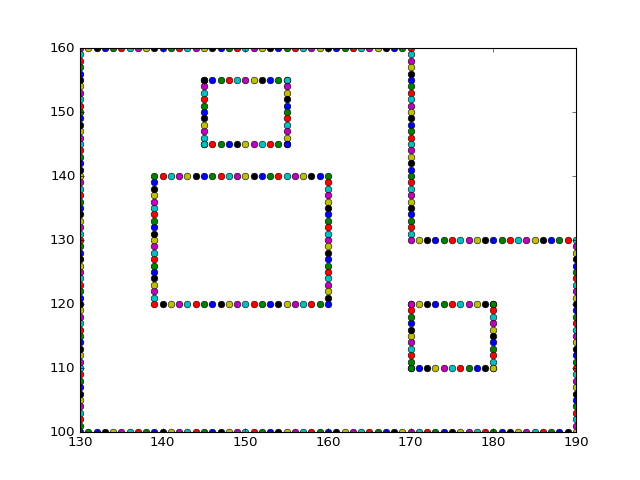

In [79]:
## just for display purpose

for boundary in list_of_boundaries:
    for points in boundary:
        plt.plot(points[0],points[1],'o')
plt.show()
    

In [80]:
minx, miny, maxx, maxy = list_all_polygons[0].bounds
longs = np.arange(minx, maxx+longitude_upper_limit, limit)
print len(longs)
lats =  np.arange(miny, maxy+latitude_upper_limit,limit)
print len(lats)

21
21


In [81]:
# all boundary point creation from set of points

minx, miny, maxx, maxy = list_all_polygons[0].bounds
longs = np.arange(minx, maxx+longitude_upper_limit, limit)
lats =  np.arange(miny, maxy+latitude_upper_limit, limit)

edges=[]
dummy = 0
for x in range(0,len(longs)):
    for y in range(0,len(lats)):
        point = Point([longs[x],lats[y]])
        if list_all_polygons[0].contains(point) or np.any(np.equal([longs[x],lats[y]] , list_of_boundaries[0]).all(axis=1)):
            if( len(list_all_polygons) > 1):
                flag_poly = True
                for obstacle_poly in list_all_polygons[1:]:
                    if obstacle_poly.contains(point):
                        flag_poly = False
                if flag_poly:
                    edges.append([longs[x],lats[y]])
                
            else:
                edges.append([longs[x],lats[y]])
                
print "Number of lawn boundary points: ",len(edges)
#2741
print [130.0, 101.0] in edges

Number of lawn boundary points:  311
False


In [82]:
current_position = edges[0][:]
current_position.extend('S')
traversed_list = []
final_list_waypoint = []
move=[[0.,-limit , 'S'],[-limit,0. , 'W'],[0.,limit ,'N'],[limit,0 ,'E']]
def move_next(current_position):
#     print(current_position)
    for i in move:
        next_x = current_position[0] + i[0]
        next_y = current_position[1] + i[1]
        theta = i[2]
        point = Point(next_x , next_y)
        if [next_x , next_y] not in traversed_list:
            if list_all_polygons[0].contains(point) or np.any(np.equal([next_x , next_y] , coordinates).all(axis=1)):
                if( len(list_all_polygons) > 1):
                    flag_poly = True
                    for obstacle_poly in list_all_polygons[1:]:
                        if obstacle_poly.contains(point):
                            flag_poly = False
                    if flag_poly:
                        return [next_x,next_y ,theta]
                else:
                    return [next_x,next_y ,theta]
    return None



while len(edges)!=0 :
    
    if current_position == None:
        current_position = edges[0][:]
        current_position.extend('S')
    
    point =  current_position[:2]
    edges.remove(point)
    traversed_list.append(current_position[:2])
    final_list_waypoint.append(current_position)
    current_position = move_next(current_position)
print(len(traversed_list))

311


## Plot the Waypoints

<IPython.core.display.Javascript object>


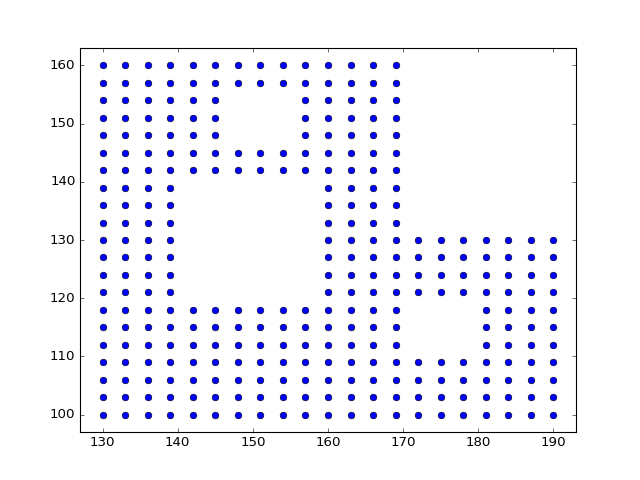

In [83]:
from matplotlib.animation import FuncAnimation

wp_arr = np.array(traversed_list)
x_coo = wp_arr[:,0].tolist()
y_coo = wp_arr[:,1].tolist()
frame = len(traversed_list)+1
fig = plt.figure()
plt.xlim(minx-limit,maxx+limit)
plt.ylim(miny-limit,maxy+limit)
graph, = plt.plot([],[],'o')
def animate(i):
    graph.set_data(x_coo[:i],y_coo[:i])
    return graph

animation= FuncAnimation(fig,animate,frames=frame,interval=10,repeat=False)
plt.show()



In [ ]:
pts = np.array(traversed_list)
# tck, u = splprep(pts.T, u=None, s=0.0, per=1) 
# u_new = np.linspace(u.min(), u.max(), 1000)
# x_new, y_new = splev(u_new, tck, der=0)

# #plt.plot(pts[:,0], pts[:,1], 'ro')
# plt.plot(x_new, y_new, 'b')
# plt.show()

from scipy.interpolate import interp1d
x, y = pts.T
i = np.arange(len(pts))

# 5x the original number of points
interp_i = np.linspace(0, i.max(), 5 * i.max())

xi = interp1d(i, x, kind='cubic')(interp_i)
yi = interp1d(i, y, kind='cubic')(interp_i)

fig, ax = plt.subplots()
ax.plot(xi, yi)
# ax.plot(x, y, 'ko')
plt.show()

In [84]:
with open("global_waypoint","w+") as obj:
    for i in final_list_waypoint:
        obj.write(' '.join(str(e) for e in i))
        obj.write('\n')
        